In [1]:
import altair as alt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
alt.data_transformers.enable('data_server')
alt.renderers.enable('mimetype')
import random
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge, RidgeCV, RidgeClassifier
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    ShuffleSplit,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PolynomialFeatures,
    StandardScaler,
)
from sklearn.svm import SVC, SVR
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import pickle
import warnings
from scipy.stats import lognorm, loguniform, randint
from sklearn.metrics import classification_report

In [2]:
X_train = pd.read_csv('../data/processed/training_feature.csv', index_col="index")
y_train = pd.read_csv('../data/processed/training_target.csv', index_col="index").loc[:,"TYPE"]

X_test = pd.read_csv('../data/processed/test_feature.csv', index_col="index")
y_test = pd.read_csv('../data/processed/test_target.csv', index_col="index").loc[:,"TYPE"]

In [3]:
file = open('../data/processed/preprocessor.p', 'rb')
preprocessor = pickle.load(file)

file = open('../data/processed/models.p', 'rb')
models = pickle.load(file)

In [4]:
## Adopted from lecture notes of DSCI 571 and DSCI 573

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [5]:
# Column Transformation

#drop_features = ["HUNDRED_BLOCK"]
#categorical_feature_n = ["NEIGHBOURHOOD"]
#categorical_features = ["YEAR", "MONTH", "DAY", "HOUR", "MINUTE"]
#numerical_features = ["X", "Y"]

# preprocessor for EDA and model training
#preprocessor = make_column_transformer(

#    (make_pipeline(
#                SimpleImputer(strategy="constant", fill_value="most_frequent"),
#                OneHotEncoder(handle_unknown="ignore", sparse=False),
#            ), categorical_feature_n,
#        ),
#
#    (OneHotEncoder(handle_unknown="ignore", drop='if_binary',
#                   sparse=False), categorical_features),
#
#    (make_pipeline(
#               SimpleImputer(strategy="most_frequent"), # these are coordinates
#               StandardScaler(),
#           ), numerical_features
#       ),
#        ("drop", drop_features),
#    )

#models = {
#    "DummyClassifier": DummyClassifier(),
#    "LogisticRegression": LogisticRegression(max_iter=1000, multi_class="ovr"),
#    "RandomForest": RandomForestClassifier(),
#    "RidgeClassifier": RidgeClassifier()
#    }

In [6]:
models

{'DummyClassifier': DummyClassifier(),
 'LogisticRegression': LogisticRegression(max_iter=1000, multi_class='ovr'),
 'RandomForest': RandomForestClassifier(),
 'RidgeClassifier': RidgeClassifier()}

In [7]:
def cv_models(models, X_train, y_train, cv=5):
    """Returns CV f1 scores
    Parameters
    ----------
    models : list
        A list of sklearn classifiers
    X_train : numpy ndarray
        The feature matrix
    y_train : numpy ndarray
        The target labels
    cv : int, optional
        Number of folds, default 5

    Returns
    -------
    pandas DataFrame
        The results of cross validation for the given models
    """
    f1_scorer = make_scorer(f1_score, average='micro')

    scoring_metrics = {

        "f1": f1_scorer,
    }

    results = {}

    for name, model in models.items():

        pipe = make_pipeline(preprocessor, model)

        results[name] = mean_std_cross_val_scores(
            pipe, X_train, y_train, cv=cv, return_train_score=True, scoring=scoring_metrics
        )

    results_df = pd.DataFrame(results)

    return results_df

In [8]:
cv_models(models, X_train, y_train, cv=5)

,DummyClassifier,LogisticRegression,RandomForest,RidgeClassifier
fit_time,0.065 (+/- 0.008),4.465 (+/- 0.071),5.736 (+/- 0.158),0.169 (+/- 0.007)
score_time,0.032 (+/- 0.001),0.054 (+/- 0.021),0.215 (+/- 0.008),0.053 (+/- 0.008)
test_f1,0.277 (+/- 0.000),0.471 (+/- 0.001),0.463 (+/- 0.003),0.467 (+/- 0.001)
train_f1,0.277 (+/- 0.000),0.478 (+/- 0.001),0.981 (+/- 0.001),0.474 (+/- 0.001)


In [9]:
# testing 
#warnings.filterwarnings("ignore")

#assert(isinstance(cv_models(models, X_train, y_train), pd.DataFrame),
#       "Error not a df type")
#assert(cv_models(models, X_train, y_train).shape[1]== 4, 'Not all the models are evaluated')

<>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:6: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:6: SyntaxWarning: assertion is always true, perhaps remove parentheses?


In [10]:
def best_LR_model(X_train, y_train):
    """
    Finds the best LR model based on C and weight class, based on f1 scorer

    Parameters
    ----------
    models : list
        A list of sklearn classifiers
    X_train : numpy ndarray
        The feature matrix


    Returns
    -------
    dictionary 
        dictionary with scores and best model with optimized hyperparameters
    """
    pipe = make_pipeline(preprocessor,
                         LogisticRegression(max_iter=1000,
                                         multi_class='ovr',))

    f1_scorer = make_scorer(f1_score, average='micro')

    scoring_metrics = {

        "f1": f1_scorer,
    }

    param_grid = {
        "logisticregression__C": [0.01, 0.1, 1, 10, 100],
        "logisticregression__class_weight": [None, "balanced"]
    }

    search = RandomizedSearchCV(
        pipe,
        param_grid,
        verbose=1,
        n_jobs=-1,
        n_iter=10,
        return_train_score=True,
        scoring=make_scorer(f1_score, average='micro'),
        random_state=123,
    )
    search.fit(X_train, y_train);

    search_df = pd.DataFrame(search.cv_results_).loc[pd.DataFrame(search.cv_results_)['rank_test_score']==1,["mean_test_score",
        "mean_train_score",
        "param_logisticregression__C",
        "param_logisticregression__class_weight"]].T

    search_df =search_df.rename(index={'param_logisticregression__C': "Best C",
                                "param_logisticregression__class_weight" : "Best weight"})

    best_C = search.best_params_['logisticregression__C']
    best_weight = search.best_params_['logisticregression__class_weight']

    dict = {'scores': search_df,
           'best_model': LogisticRegression(max_iter=1000,
                                           multi_class='ovr',
                                           C=best_C,
                                           class_weight=best_weight)
           }

    return dict

In [11]:
results= best_LR_model(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [12]:
#warnings.filterwarnings("ignore")

#assert(len(best_LR_model(X_train, y_train))== 2, 'Error dict is not complete')

#assert(isinstance(best_LR_model(X_train, y_train), dict),
#       "Error not a dict type")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [13]:
pipe_best = make_pipeline(preprocessor, results['best_model'] )

In [14]:
def print_scores(pipe):

    warnings.filterwarnings("ignore")

    pipe.fit(X_train, y_train)

    print(classification_report(y_test, pipe.predict(X_test), target_names=pipe.classes_));

    y_preb_probs = pipe_best.predict_proba(X_test)
    print(f"MODEL'S ROC AUC SCORE IS : {round(roc_auc_score(y_test, y_preb_probs, average='weighted', multi_class='ovr'), 3)}")

In [15]:
print_scores(pipe_best)

                                                        precision    recall  f1-score   support

                            Break and Enter Commercial       0.33      0.15      0.20       526
                     Break and Enter Residential/Other       0.33      0.06      0.11       390
                                              Homicide       0.00      0.00      0.00         6
                                              Mischief       0.31      0.11      0.16      1234
                              Offence Against a Person       0.99      1.00      1.00       758
                                           Other Theft       0.43      0.59      0.50      1739
                                    Theft from Vehicle       0.44      0.75      0.55      2103
                                      Theft of Bicycle       0.00      0.00      0.00       398
                                      Theft of Vehicle       0.00      0.00      0.00       174
Vehicle Collision or Pedestrian Struck 

In [16]:
def print_confusion_matrix(pipe):
    pipe.fit(X_train, y_train)

    cm = ConfusionMatrixDisplay.from_estimator(
    pipe, X_test, y_test, values_format="d", display_labels=pipe.classes_
    ).figure_

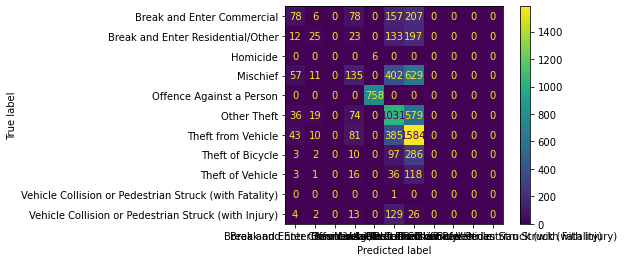

In [17]:
print_confusion_matrix(pipe_best)